In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nbconvert import PythonExporter
import os
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, log_loss
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks, regularizers
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg, resize
from tensorflow import one_hot, cast, float32
from keras.applications.xception import preprocess_input
from tensorflow.data import Dataset, AUTOTUNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-09-09 09:42:00.009025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757410920.260264      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757410920.335092      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Loading data ####

In [2]:
# adding the images, labels, styles
file_path = "/kaggle/input/wikiart-all-artpieces/wikiart_art_pieces.csv"
df = pd.read_csv(file_path)
df.head()

,artist,style,genre,movement,tags,url,img,file_name
0,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Byzantinearchitecture', 'Arch'...",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,0-ravenna-cappella-arcivescovile-166.jpg
1,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Byzantinearchitecture', 'Arch']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,1-ravenna-cappella-arcivescovile-167.jpg
2,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Prophet', 'History']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,2-ravenna-cappella-arcivescovile-168.jpg
3,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Prophet']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,3-ravenna-cappella-arcivescovile-169.jpg
4,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Prophet']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,4-ravenna-cappella-arcivescovile-171.jpg


In [3]:
df.shape

(176436, 8)

In [4]:
def filter_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """clean the dataframe to keep categories wanted"""

    #lists :
    styles_to_keep = ['Orientalism', 'Neoclassicism', 'Naturalism', 'Romanticism', 'Academicism', 'Neo-Rococo', 'Kitsch', 'Realism', 'Impressionism', 'Expressionism', 'Japonism', 'Magic Realism', 'Symbolism', 'Costumbrismo', 'Biedermeier', 'Luminism', 'Ink and wash painting', 'Naïve Art (Primitivism)', 'Art Nouveau (Modern)', 'Divisionism', 'Social Realism', 'Tonalism', 'Post-Impressionism', 'Pointillism', 'Ukiyo-e', 'American Realism', 'Socialist Realism', 'Fauvism', 'Cubism', 'Abstract Art', 'Precisionism', 'Figurative Expressionism', 'Existential Art', 'Surrealism', 'New Realism', 'Neo-baroque', 'Abstract Expressionism', 'Neo-Romanticism', 'Neo-Impressionism', 'Cloisonnism', 'Synthetism', 'Regionalism', 'Orphism', 'Art Deco', 'Neo-Expressionism', 'Fantasy Art', 'New Medievialism', 'Neo-Byzantine', 'Lyrical Abstraction', 'New Ink Painting', 'Verism', 'Contemporary Realism', 'Color Field Painting', 'Art Brut', 'Outsider art', 'Cubo-Expressionism', 'Pop Art', 'Geometric', 'Art Singulier', 'Action painting', 'Constructivism', 'Neoplasticism', 'Intimism', 'Dada', 'Analytical Cubism', 'Synthetic Cubism', 'Muralism', 'Futurism', 'Cubo-Futurism', 'Tachisme', 'Modernismo', 'Metaphysical art', 'Excessivism', 'Classical Realism', 'Severe Style', 'Miserablism', 'Art Informel', 'Neo-Pop Art', 'Native Art', 'Transavantgarde', 'Contemporary', 'Conceptual Art', 'Light and Space', 'Junk Art', 'Shin-hanga', 'Hard Edge Painting', 'Neo-Figurative Art', 'Purism', 'Tubism', 'Suprematism', 'Concretism', 'Analytical\xa0Realism', 'Mechanistic Cubism', 'Neo-Suprematism', 'Automatic Painting', 'Op Art', 'Minimalism', 'Post-Minimalism', 'Post-Painterly Abstraction', 'Neo-Concretism', 'Lettrism', 'Kinetic Art', 'New European Painting', 'P&D (Pattern and Decoration)', 'New Casualism', 'Neo-Dada', 'Spectralism', 'Rayonism', 'Synchromism', 'Modernism', 'Feminist Art', 'Transautomatism', 'Fantastic Realism', 'Photorealism', 'Hyper-Realism', 'Nouveau Réalisme', 'Postcolonial art', 'Sots Art', 'Indian Space painting', 'Zen', 'Spatialism', 'Cartographic Art', 'Superflat', 'Mail Art', 'Neo-Minimalism', 'Fiber art', 'Street art', 'Neo-Geo', 'Maximalism', 'Queer art', 'Digital Art', 'Cyber Art', 'Poster Art Realism', 'Hyper-Mannerism (Anachronism)', 'Confessional Art', 'Neo-Orthodoxism', 'Graffiti Art', 'Lowbrow Art', 'Stuckism']
    genres_to_drop = ['sketch and study', 'sculpture', 'design', 'installation', 'no genre', 'photo', 'poster', 'caricature', 'graffiti', 'advertisement', 'utensil', 'veduta', 'performance', 'capriccio', 'mural', 'bird-and-flower painting', 'digital', 'architecture', 'mobile', 'miniature', 'tapestry', 'pastorale', 'furniture', 'calligraphy', 'shan shui', 'mosaic', 'vanitas', 'jewelry', 'pin-up', 'video', "trompe-l'œil", 'panorama', 'stabile', 'augmented reality', 'quadratura', 'object', "artist's book", 'ornament', 'animation', 'tronie']

    #Clean the styles
    df_cleaned_styles = df[df['style'].isin(styles_to_keep)]

    #Clean the movement
    df_cleaned_styles_movements = df_cleaned_styles[df_cleaned_styles['movement'].isin(styles_to_keep)]

    #Create a copy of the dataframe and split the genres to a list (multiple values possibles)
    df_cleaned_styles_movements_copy = df_cleaned_styles_movements.copy()
    df_cleaned_styles_movements_copy['genre_list'] = df_cleaned_styles_movements_copy['genre'].str.split(',\s*', regex=True)
    df_cleaned_styles_movements_copy = df_cleaned_styles_movements_copy.drop(columns='genre')

    # Clean the genres (chosed the ones to drop)
    df_cleaned_styles_movement_genres = df_cleaned_styles_movements_copy[df_cleaned_styles_movements_copy['genre_list'].apply(
        lambda x: all(genre not in genres_to_drop for genre in x) if isinstance(x, list) else True
    )]

    df_filtered = df_cleaned_styles_movement_genres.drop_duplicates(subset=['img'], keep='first')
    df_filtered = df_filtered.set_index("file_name", drop=False)
    return df_filtered

In [5]:
df = filter_dataframe(df)

In [6]:
df.shape

(115055, 8)

In [7]:
df['style'].value_counts()

style
Impressionism         15301
Romanticism           13208
Realism               12730
Expressionism         10263
Post-Impressionism     7166
                      ...  
Geometric                 4
New Ink Painting          3
Kinetic Art               2
Rayonism                  1
Shin-hanga                1
Name: count, Length: 135, dtype: int64

In [8]:
counts = df['style'].value_counts()
rare_styles = counts[counts < 200]
print(rare_styles)

style
Neo-baroque          199
Classical Realism    198
Constructivism       190
Street art           188
Muralism             186
                    ... 
Geometric              4
New Ink Painting       3
Kinetic Art            2
Rayonism               1
Shin-hanga             1
Name: count, Length: 79, dtype: int64


In [9]:
df_filtered = df[df['style'].map(df['style'].value_counts()) > 200]

In [10]:
df_filtered.shape

(109618, 8)

In [11]:
df_filtered['style'].value_counts()

style
Impressionism                 15301
Romanticism                   13208
Realism                       12730
Expressionism                 10263
Post-Impressionism             7166
Surrealism                     6045
Symbolism                      4632
Abstract Expressionism         3457
Neoclassicism                  2306
Cubism                         2130
Pop Art                        2072
Art Nouveau (Modern)           1967
Art Informel                   1666
Magic Realism                  1552
Abstract Art                   1445
Contemporary Realism           1422
Neo-Expressionism              1339
Minimalism                     1223
Color Field Painting           1222
Orientalism                    1142
Lyrical Abstraction            1091
Fauvism                        1056
Naïve Art (Primitivism)         971
Neo-Impressionism               961
Academicism                     892
Op Art                          757
Naturalism                      707
Neo-Romanticism       

In [12]:
num_style = df_filtered['style'].nunique()
num_style

56

In [13]:
df_filtered['style'].unique()

array(['Neoclassicism', 'Orientalism', 'Romanticism', 'Academicism',
       'Kitsch', 'Realism', 'Naturalism', 'Impressionism',
       'Expressionism', 'Magic Realism', 'Symbolism', 'Biedermeier',
       'Luminism', 'Naïve Art (Primitivism)', 'Art Nouveau (Modern)',
       'Divisionism', 'Social Realism', 'Tonalism', 'Post-Impressionism',
       'Socialist Realism', 'Fauvism', 'Cubism', 'Abstract Art',
       'Precisionism', 'Figurative Expressionism', 'Surrealism',
       'Abstract Expressionism', 'Neo-Romanticism', 'Neo-Impressionism',
       'Regionalism', 'Art Deco', 'Neo-Expressionism',
       'Lyrical Abstraction', 'Contemporary Realism',
       'Color Field Painting', 'Pop Art', 'Dada', 'Synthetic Cubism',
       'Futurism', 'Tachisme', 'Metaphysical art', 'Art Informel',
       'Neo-Pop Art', 'Native Art', 'Transavantgarde', 'Contemporary',
       'Hard Edge Painting', 'Concretism', 'Op Art', 'Minimalism',
       'Conceptual Art', 'Post-Painterly Abstraction',
       'New Europ

In [14]:
df = df_filtered.copy()

In [15]:
df.shape

(109618, 8)

In [16]:
list_images= df['file_name'].unique().tolist()

#### Loading and resize images ####

In [17]:
#create full path column in df
df["filepath"] = df["file_name"].apply(
    lambda x: os.path.join("/kaggle/input/wikiart-all-artpieces/wikiart/wikiart", x)
)
df.head()

,artist,style,movement,tags,url,img,file_name,genre_list,filepath
file_name,,,,,,,,,
28564-the-waterfalls-at-tivoli.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,"['Nature', 'Naturallandscape', 'Atmosphericphe...",https://www.wikiart.org/en/claude-joseph-verne...,https://uploads5.wikiart.org/00128/images/clau...,28564-the-waterfalls-at-tivoli.jpg,[landscape],/kaggle/input/wikiart-all-artpieces/wikiart/wi...
28565-the-bridge-and-the-castel-sant-angelo-in-rome.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,"['Waterway', 'Watercraftrowing', 'Gondola', 'B...",https://www.wikiart.org/en/claude-joseph-verne...,https://uploads8.wikiart.org/00128/images/clau...,28565-the-bridge-and-the-castel-sant-angelo-in...,[landscape],/kaggle/input/wikiart-all-artpieces/wikiart/wi...
28566-villa-at-caprarola.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,"['Sky', 'Ruralarea', 'Highland', 'Hill']",https://www.wikiart.org/en/claude-joseph-verne...,https://uploads8.wikiart.org/00128/images/clau...,28566-villa-at-caprarola.jpg,[landscape],/kaggle/input/wikiart-all-artpieces/wikiart/wi...
28567-vedi-titolo.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,"['Sky', 'Cloud', 'Horizon', 'Atmosphere', 'Eco...",https://www.wikiart.org/en/claude-joseph-verne...,https://uploads1.wikiart.org/00128/images/clau...,28567-vedi-titolo.jpg,[cloudscape],/kaggle/input/wikiart-all-artpieces/wikiart/wi...
28568-night-a-port-in-the-moonlight-1748.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,['Sky'],https://www.wikiart.org/en/claude-joseph-verne...,https://uploads0.wikiart.org/00259/images/clau...,28568-night-a-port-in-the-moonlight-1748.jpg,[marina],/kaggle/input/wikiart-all-artpieces/wikiart/wi...


#### Define X and y ####

In [18]:
X = df["filepath"]
y = df['style']

In [19]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (109618,)
y shape: (109618,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

#### Encode labels ####

In [21]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Create tensorflow dataset

In [22]:
NUM_CLASSES = len(le.classes_)
NUM_CLASSES

56

In [23]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [24]:
def is_valid_image(path):
    """Retourne True si l'image peut être décodée, False sinon"""
    try:
        img = read_file(path)
        decode_jpeg(img, channels=3)
        return True
    except:
        return False

def process_image(path, label):
    """Lit, redimensionne, normalise l'image et encode le label en one-hot"""
    img = read_file(path)
    img = decode_jpeg(img, channels=3)
    img = resize(img, IMG_SIZE)
    img = preprocess_input(img)
    
    label_one_hot = one_hot(label, depth=NUM_CLASSES)
    label_one_hot = cast(label_one_hot, float32)
    
    return img, label_one_hot

def filter_valid_images(paths, labels):
    """Filtre les images corrompues et retourne les listes valides"""
    valid_paths, valid_labels = [], []
    invalid_paths = []
    
    for p, l in zip(paths, labels):
        if is_valid_image(p):
            valid_paths.append(p)
            valid_labels.append(l)
        else:
            invalid_paths.append(p)
    
    print(f"⚠️ Images invalides : {len(invalid_paths)}")
    if invalid_paths:
        print(invalid_paths[:10])  # montrer les premières images corrompues
    
    return valid_paths, valid_labels

In [25]:
# filter valid images
X_train_valid, y_train_valid = filter_valid_images(X_train, y_train_encoded)
X_test_valid, y_test_valid = filter_valid_images(X_test, y_test_encoded)

I0000 00:00:1757410935.813110      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757410935.813839      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


⚠️ Images invalides : 1
['/kaggle/input/wikiart-all-artpieces/wikiart/wikiart/35889-screenshot-2021-12-21-152829.png']
⚠️ Images invalides : 1
['/kaggle/input/wikiart-all-artpieces/wikiart/wikiart/118309-ambroise-vollard.jpg']


In [26]:
# Create tensorflow dataset secured
train_dataset = Dataset.from_tensor_slices((X_train_valid, y_train_valid))
train_dataset = train_dataset.map(process_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_dataset = Dataset.from_tensor_slices((X_test_valid, y_test_valid))
val_dataset = val_dataset.map(process_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Load model

In [27]:
from tensorflow import keras

# Charger le modèle
model = keras.models.load_model("/kaggle/input/model-before-finetuning/model_Xception_alldata.keras")

### finetuning

In [28]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer_4 True
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_16 False
13 block2_pool False
14 batch_normalization_16 False
15 add_48 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_17 False
23 block3_pool False
24 batch_normalization_17 False
25 add_49 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_18 False
33 block4_pool False
34 batch_normalization_18 False
35 add_50 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 b

In [29]:
for layer in model.layers[100:132]:  # Excluding the layers we add ourself
    layer.trainable = True


In [30]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer_4 True
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_16 False
13 block2_pool False
14 batch_normalization_16 False
15 add_48 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_17 False
23 block3_pool False
24 batch_normalization_17 False
25 add_49 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_18 False
33 block4_pool False
34 batch_normalization_18 False
35 add_50 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 b

In [31]:
# Recompiler avec un learning rate plus petit
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss',
                   patience = 10,
                   verbose = 1,
                   restore_best_weights = True)

history_phase2 = model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=100,
                           callbacks=[es])

Epoch 1/100


I0000 00:00:1757412221.974627      96 service.cc:148] XLA service 0x7af774003140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757412221.975718      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757412221.975741      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757412223.551497      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1757412236.060542      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757412236.200479      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1757412241.486507      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:12 225ms/step - accuracy: 0.3561 - loss: 2.4187

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2397/2398 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.3786 - loss: 2.3267

E0000 00:00:1757412788.705499      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757412788.844254      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 753s 300ms/step - accuracy: 0.3787 - loss: 2.3266 - val_accuracy: 0.4350 - val_loss: 2.1120
Epoch 2/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:12 224ms/step - accuracy: 0.4390 - loss: 2.0826

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 692s 288ms/step - accuracy: 0.4454 - loss: 2.0633 - val_accuracy: 0.4510 - val_loss: 2.0583
Epoch 3/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 224ms/step - accuracy: 0.4681 - loss: 1.9699

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 692s 288ms/step - accuracy: 0.4722 - loss: 1.9587 - val_accuracy: 0.4585 - val_loss: 2.0323
Epoch 4/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:12 224ms/step - accuracy: 0.4895 - loss: 1.8923

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 693s 289ms/step - accuracy: 0.4944 - loss: 1.8789 - val_accuracy: 0.4619 - val_loss: 2.0188
Epoch 5/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:10 223ms/step - accuracy: 0.5121 - loss: 1.8186

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 693s 288ms/step - accuracy: 0.5149 - loss: 1.8092 - val_accuracy: 0.4669 - val_loss: 2.0069
Epoch 6/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:10 223ms/step - accuracy: 0.5341 - loss: 1.7430

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 693s 288ms/step - accuracy: 0.5353 - loss: 1.7372 - val_accuracy: 0.4696 - val_loss: 2.0035
Epoch 7/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 224ms/step - accuracy: 0.5452 - loss: 1.6907

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 690s 287ms/step - accuracy: 0.5487 - loss: 1.6807 - val_accuracy: 0.4721 - val_loss: 2.0056
Epoch 8/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:12 224ms/step - accuracy: 0.5665 - loss: 1.6233

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 693s 288ms/step - accuracy: 0.5676 - loss: 1.6132 - val_accuracy: 0.4729 - val_loss: 2.0026
Epoch 9/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 223ms/step - accuracy: 0.5823 - loss: 1.5592

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 690s 287ms/step - accuracy: 0.5841 - loss: 1.5512 - val_accuracy: 0.4724 - val_loss: 2.0141
Epoch 10/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:10 223ms/step - accuracy: 0.6000 - loss: 1.5015

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 689s 287ms/step - accuracy: 0.6010 - loss: 1.4949 - val_accuracy: 0.4734 - val_loss: 2.0272
Epoch 11/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 223ms/step - accuracy: 0.6131 - loss: 1.4454

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 691s 288ms/step - accuracy: 0.6159 - loss: 1.4362 - val_accuracy: 0.4727 - val_loss: 2.0407
Epoch 12/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 224ms/step - accuracy: 0.6314 - loss: 1.3798

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 691s 288ms/step - accuracy: 0.6340 - loss: 1.3751 - val_accuracy: 0.4728 - val_loss: 2.0617
Epoch 13/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 223ms/step - accuracy: 0.6533 - loss: 1.3195

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 691s 288ms/step - accuracy: 0.6543 - loss: 1.3150 - val_accuracy: 0.4721 - val_loss: 2.0945
Epoch 14/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 224ms/step - accuracy: 0.6658 - loss: 1.2713

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 693s 288ms/step - accuracy: 0.6697 - loss: 1.2635 - val_accuracy: 0.4708 - val_loss: 2.1173
Epoch 15/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:12 224ms/step - accuracy: 0.6824 - loss: 1.2100

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 692s 288ms/step - accuracy: 0.6863 - loss: 1.2039 - val_accuracy: 0.4697 - val_loss: 2.1453
Epoch 16/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 223ms/step - accuracy: 0.7016 - loss: 1.1491

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 692s 288ms/step - accuracy: 0.7039 - loss: 1.1434 - val_accuracy: 0.4682 - val_loss: 2.1901
Epoch 17/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 223ms/step - accuracy: 0.7193 - loss: 1.0977

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 691s 288ms/step - accuracy: 0.7206 - loss: 1.0951 - val_accuracy: 0.4660 - val_loss: 2.2353
Epoch 18/100
1005/2398 ━━━━━━━━━━━━━━━━━━━━ 5:11 224ms/step - accuracy: 0.7355 - loss: 1.0442

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


2398/2398 ━━━━━━━━━━━━━━━━━━━━ 692s 288ms/step - accuracy: 0.7374 - loss: 1.0388 - val_accuracy: 0.4667 - val_loss: 2.2881
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.


In [32]:
model.save("/kaggle/working/model_Xception_alldata_finetuned.keras")

In [34]:
model.evaluate(val_dataset, return_dict=True)

1028/1028 ━━━━━━━━━━━━━━━━━━━━ 155s 151ms/step - accuracy: 0.4707 - loss: 2.0248


{'accuracy': 0.4729207754135132, 'loss': 2.0026392936706543}

In [37]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

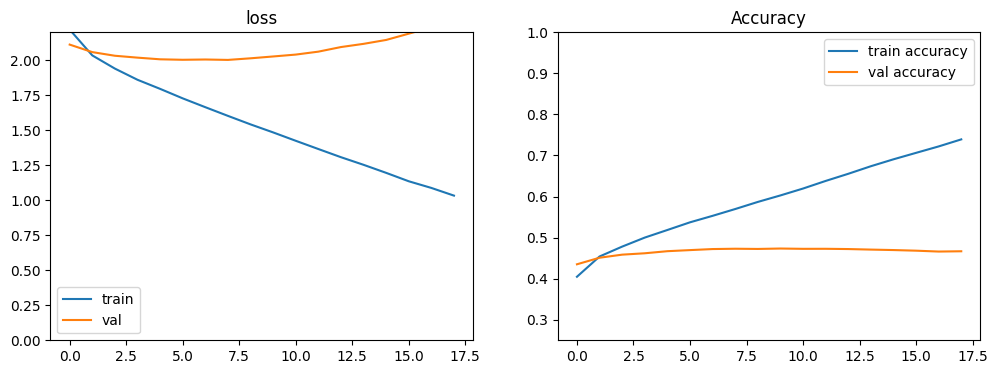

In [38]:
plot_history(history_phase2)

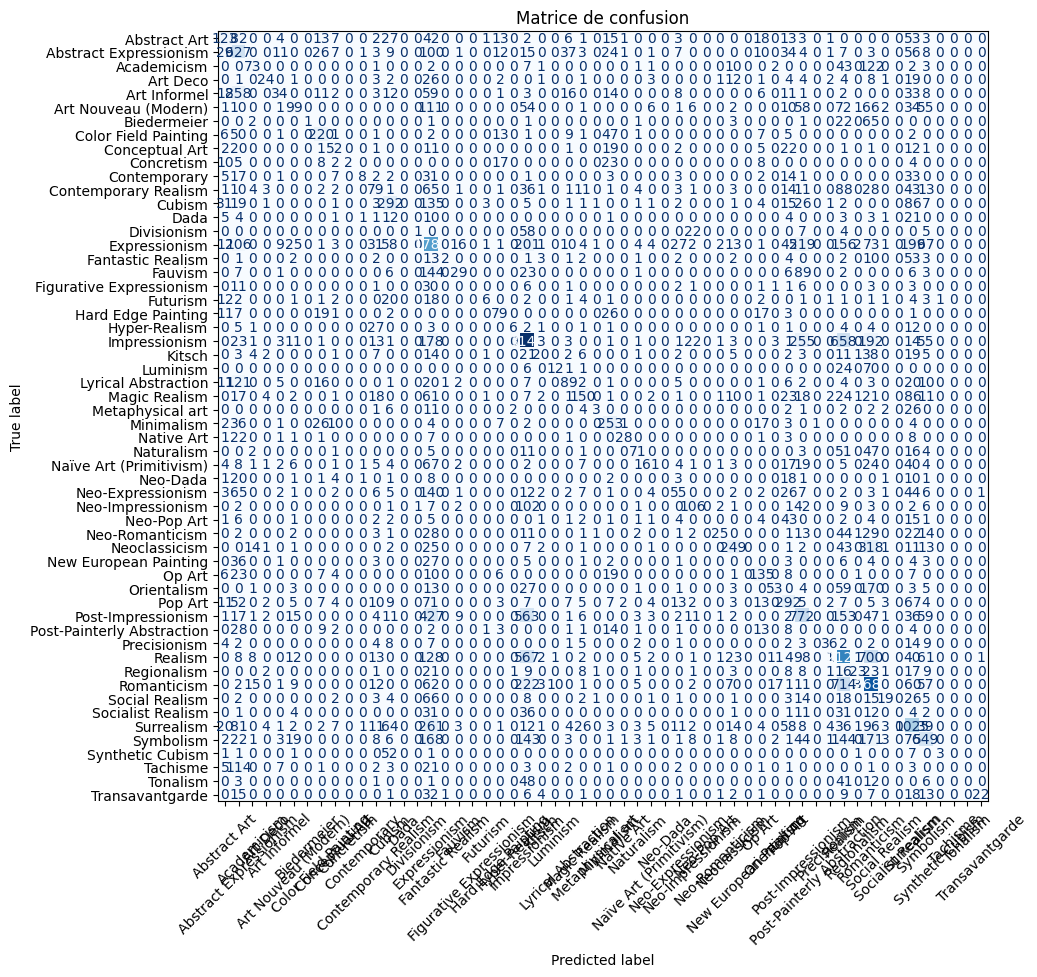

In [39]:
# 1. Prédictions sur tout le val_dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    
    y_true.extend(np.argmax(labels.numpy(), axis=1))   # labels vrais
    y_pred.extend(np.argmax(preds, axis=1))            # labels prédits

# 2. Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# 3. Affichage
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
disp.plot(cmap="Blues", xticks_rotation=45, ax=plt.gca(), colorbar=False)
plt.title("Matrice de confusion")
plt.show()

In [40]:
images_paths = ["/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg",
                "/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg",
                "/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg",
                "/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

In [41]:
images_list = []

for img_path in images_paths :
            img = Image.open(img_path).convert('RGB')

            img_resized = img.resize((224, 224), Image.BICUBIC)

            img_array = np.array(img_resized)

            image_preprocessed = preprocess_input(img_array)
            # convert into an array and add to list
            images_list.append(image_preprocessed)

images_np = np.stack(images_list)

In [42]:
X_eval = images_np

In [43]:
preds = model.predict(X_eval)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[7.90131708e-06 1.00845173e-05 1.75747089e-04 9.94411996e-04
  3.52391476e-06 9.12087504e-03 5.26460703e-04 2.20017938e-07
  1.12455700e-06 5.64561589e-08 2.94863057e-05 3.98090947e-03
  1.13927163e-02 4.16126604e-05 1.77771610e-04 1.47487551e-01
  1.45344384e-05 7.85162859e-03 1.22688187e-04 9.40634491e-05
  6.36256630e-08 4.31574008e-05 1.94009934e-02 1.03290869e-04
  2.56297631e-06 8.32641831e-07 7.15367543e-03 1.98577833e-03
  1.85867872e-08 9.75884745e-07 1.05261058e-03 6.91240607e-03
  1.45618114e-05 1.92046704e-04 9.03864740e-04 6.47345905e-06
  7.82129448e-03 7.83724245e-04 4.54953115e-05 3.24222270e-07
  1.71449885e-03 2.19729540e-04 6.12121165e-01 8.59509868e-08
  3.27652786e-04 1.17049165e-01 1.21782459e-02 6.26076292e-03
  3.41215683e-03 1.04491282e-02 1.61956216e-03 5.95163042e-03
  2.30698024e-05 1.70614828e-06 1.45820304e-05 1.99323869e-04]
 [3.89266796e-02 5.40237948e-02 2.84900170e-06 3.07278853e-04
  1.88212562e-02 1.59094023e-04 2

In [44]:
list_styles = ['Abstract Art',
 'Abstract Expressionism',
 'Academicism',
 'Art Deco',
 'Art Informel',
 'Art Nouveau (Modern)',
 'Biedermeier',
 'Color Field Painting',
 'Conceptual Art',
 'Concretism',
 'Contemporary',
 'Contemporary Realism',
 'Cubism',
 'Dada',
 'Divisionism',
 'Expressionism',
 'Fantastic Realism',
 'Fauvism',
 'Figurative Expressionism',
 'Futurism',
 'Hard Edge Painting',
 'Hyper-Realism',
 'Impressionism',
 'Kitsch',
 'Luminism',
 'Lyrical Abstraction',
 'Magic Realism',
 'Metaphysical art',
 'Minimalism',
 'Native Art',
 'Naturalism',
 'Naïve Art (Primitivism)',
 'Neo-Dada',
 'Neo-Expressionism',
 'Neo-Impressionism',
 'Neo-Pop Art',
 'Neo-Romanticism',
 'Neoclassicism',
 'New European Painting',
 'Op Art',
 'Orientalism',
 'Pop Art',
 'Post-Impressionism',
 'Post-Painterly Abstraction',
 'Precisionism',
 'Realism',
 'Regionalism',
 'Romanticism',
 'Social Realism',
 'Socialist Realism',
 'Surrealism',
 'Symbolism',
 'Synthetic Cubism',
 'Tachisme',
 'Tonalism',
 'Transavantgarde']

In [45]:
# indices
pred_indices = preds.argmax(axis=1)

# labels
pred_labels = []
for pred in pred_indices: 
    pred_labels.append(list_styles[pred])

pred_labels

['Post-Impressionism', 'Conceptual Art', 'Romanticism', 'Post-Impressionism']

In [46]:
for img_name, label, pred in zip(images_paths, pred_labels, preds):
    print(f"{img_name} : {label} ({pred.max():.2f})")

/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg : Post-Impressionism (0.61)
/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg : Conceptual Art (0.16)
/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg : Romanticism (0.80)
/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg : Post-Impressionism (0.48)
